## Konlpy를 이용한 TDM 만들기

In [1]:
import numpy as np 
import pandas as pd
from tqdm import tqdm
import re

In [2]:
df = pd.read_csv('news_data.csv', encoding = 'cp949')
df.head(10)

,date,contents,section
0,20200501,앵커 오는 일부터 전 국민에게 긴급 재난지원금을 나눠준다는데 이게 그냥 가만히...,101
1,20200501,미국 유명 래퍼 트래비스 스콧이 지난 일 연 콘서트에 만 명이 몰렸다 ...,101
2,20200501,근로장려세제처럼 환급형 세액공제로 해야 면세자는 기부해도 못 돌려받아저소득층...,101
3,20200501,코로나 항체검사 시행 시 숨겨진 감염자 확인 가능 국내도 코로나 감염 모른...,101
4,20200501,머니투데이,101
5,20200501,머니투데이 세종,101
6,20200501,사례 씨는 직장 근처에 전셋집을 구해 계약서를 썼다 그러나 집주인의 사정으로 계약...,101
7,20200501,한경 지자체 전수 조사광역단체 곳 중복 지급긴급재난지원금 코로나지원금 지급을 위...,101
8,20200501,뉴스데스크 앵커 항공 여행 업계가 코로나 로 직격탄을 맞으면서 면세점들도 덩달아...,101
9,20200501,국내 주요 면세점들은 코로나 사태로 관광객이 줄면서 재고가 늘어나자 인천 영종...,101


In [3]:
data = pd.DataFrame(df.groupby(['date', 'section'])['contents'].apply(lambda x : ','.join(x))).reset_index()

In [4]:
data.head()

,date,section,contents
0,20200123,101,일자리 대전환시대 일자리 못 만드는 중후장대산업차산업 전동화 자동화시대 전환 명...
1,20200123,102,윤석열 검찰총장 왼쪽 과 이성윤 서울중앙지검장 연합뉴스 뉴스 이성윤 사법연...
2,20200123,103,김지은의 삶도 인터뷰 배우 정영주안해본 알바 없고 성추행범 퇴치도 여러 번 ...
3,20200123,104,중국 연구진 유전자 분석 결과 국제학술지 게재 식재료로 뱀 파는 우한 해산물도매시...
4,20200123,105,무료체험 만명중 만명 자동 유료전환 전환율 달해유튜브 슬그머니 유...


In [5]:
from konlpy.tag import Okt
okt = Okt()

In [6]:
stop_words = ['이다','하다','돼다','되다']
with open("stopwords.txt", "r") as f :
    for line in f.readlines() :
        line = line.strip('\n')
        stop_words.append(line)


In [7]:
data_okt = []

texts = list(data.contents)
for i in tqdm(range(len(texts))) :
    token = []
    try :
        token = okt.nouns(texts[i])
        token = [word for word in token if not word in stop_words]
        data_okt.append(token)
    except :
        data_okt.append(texts[i])

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [03:32<00:00,  2.35it/s]


In [8]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_okt)

In [10]:
threshold = 3
total_cnt = len(tokenizer.word_index) 
rare_cnt = 0 

for key, value in tokenizer.word_counts.items():
    if(value < threshold):
        rare_cnt = rare_cnt + 1

print('단어 총 갯수 :',total_cnt)
print('2번 이상으로 안 나온 단어 수 %s: %s'%(threshold - 1, rare_cnt))
print("단어에서 2번이상으로 안나온 단어들 비율:", (rare_cnt / total_cnt)*100)

단어 총 갯수 : 29010
2번 이상으로 안 나온 단어 수 2: 12957
단어에서 2번이상으로 안나온 단어들 비율: 44.663908996897625


In [11]:
data_okt_join = [','.join(word) for word in data_okt]

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=total_cnt-rare_cnt)
tdm = cv.fit_transform(data_okt_join)

In [13]:
word_count = pd.DataFrame({
    '단어' : cv.get_feature_names(),
    '빈도' : tdm.sum(axis = 0).flat
})

In [14]:
word_count.shape

(16053, 2)

### SVD

In [15]:
X_train = tdm[:400, :]
X_test = tdm[400:, :]

In [16]:
X_train.shape

(400, 16053)

In [17]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=15, random_state=555)
svd.fit(X_train)

TruncatedSVD(n_components=15, random_state=555)

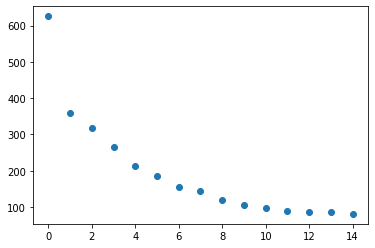

In [18]:
import matplotlib.pyplot as plt
plt.plot(svd.explained_variance_, 'o')
plt.show()

In [19]:
svd = TruncatedSVD(n_components=6, random_state=555)
svd.fit(X_train)

TruncatedSVD(n_components=6, random_state=555)

In [20]:
loading = pd.DataFrame(svd.components_.T)
loading['word'] = cv.get_feature_names()

In [36]:
loading.sort_values(2, ascending=False).loc[:,['word']]

,word
15805,환자
5560,병원
9872,우한
9910,울산
8177,신종
...,...
4041,만원
11890,정부
4694,미국
15136,한국


## 단어 의미 분석

In [37]:
svd.components_.shape

(6, 16053)

In [38]:
word_emb = svd.components_.T

In [39]:
word_emb.shape

(16053, 6)

In [40]:
words = cv.get_feature_names()

In [41]:
i = words.index('번방')
i

5373

In [42]:
word_emb[i]

array([ 0.00425214,  0.00390684,  0.00592557, -0.01431209, -0.01345775,
        0.00031178])

In [43]:
from  sklearn.metrics.pairwise import cosine_similarity
sim = cosine_similarity(word_emb, word_emb)

In [44]:
import numpy as np

rank = np.argsort(sim[i])
for j in rank[-6:-1]:
    print(words[j])

스티커
수법
퇴장
음란물
양은


## For LDA

In [45]:
X_train_101 = X_train[[x for x in range(X_train.shape[0]) if x % 5 == 0]]
X_train_102 = X_train[[x+1 for x in range(X_train.shape[0]) if x % 5 == 0]]
X_train_103 = X_train[[x+2 for x in range(X_train.shape[0]) if x % 5 == 0]]
X_train_104 = X_train[[x+3 for x in range(X_train.shape[0]) if x % 5 == 0]]
X_train_105 = X_train[[x+4 for x in range(X_train.shape[0]) if x % 5 == 0]]

In [46]:
for i in range(5) :
    globals()['X_test_{}'.format(i+1)] = X_test[[x+i for x in range(X_test.shape[0]) if x % 5 == 0 ]]

In [47]:
from gensim.matutils import Sparse2Corpus

In [48]:
i = 1
for X_train_ in [X_train_101, X_train_102, X_train_103, X_train_104,X_train_105] :
    globals()['corpus_{}'.format(i)]= Sparse2Corpus(X_train_.T) 
    id2word = dict(enumerate(cv.get_feature_names()))
    i += 1

In [49]:
for i in range(5) :
    globals()['corpus_test_{}'.format(i+1)] = Sparse2Corpus(globals()['X_test_{}'.format(i+1)].T)

## LDA

In [51]:
from gensim.models import CoherenceModel

In [52]:
from gensim.models.ldamodel import LdaModel

In [55]:
word_probs = []
for i in range(5) :
    best_score = 0
    best_num_topics = 0
    section = ['경제','사회','생활/문화','세계','IT/과학']
    print('%s 분야 데이터'%(section[i]))
    for num_topics in [3,4,5]:
            globals()['models_{}'.format(num_topics)] = LdaModel(
            corpus=globals()['corpus_{}'.format(i+1)],
            num_topics=num_topics,
            passes=3,
            iterations=30,
            id2word=id2word,
            random_state=55)
            log_pp = globals()['models_{}'.format(num_topics)].log_perplexity(globals()['corpus_test_{}'.format(i+1)])
            coh = CoherenceModel(model=globals()['models_{}'.format(num_topics)], corpus=globals()['corpus_test_{}'.format(i+1)], coherence='u_mass')
            print(i, globals()['models_{}'.format(num_topics)],"혼란도: ",2 ** (-log_pp),"응집도: ",coh.get_coherence())
            if num_topics == 3 :
                best_score = 2 **(-log_pp)
                best_num_topics = num_topics
            else :
                if 2 **(-log_pp) < best_score : 
                    best_score = 2 **(-log_pp)
                    best_num_topics = num_topics
            
    for words in globals()['models_{}'.format(best_num_topics)].show_topics(formatted=False,num_words=8, num_topics = best_num_topics):
        print(words[0])
        print("******************************")
        
        for word_prob in words[1]:
            print(word_prob)
            word_probs.append((i, word_prob[0],words[0]))
        print("")
        print("******************************")

경제 분야 데이터
0 LdaModel(num_terms=16053, num_topics=3, decay=0.5, chunksize=2000) 혼란도:  608.0651015177192 응집도:  -0.6008614374832613
0 LdaModel(num_terms=16053, num_topics=4, decay=0.5, chunksize=2000) 혼란도:  702.3730216247113 응집도:  -1.54486699808366
0 LdaModel(num_terms=16053, num_topics=5, decay=0.5, chunksize=2000) 혼란도:  833.07070432503 응집도:  -0.7327055402155238
0
******************************
('마스크', 0.0041308845)
('코로나', 0.0039166645)
('미국', 0.0034998537)
('중국', 0.0034626767)
('정부', 0.0033105419)
('억원', 0.0029899974)
('갤럭시', 0.002973986)
('사진', 0.002956167)

******************************
1
******************************
('코로나', 0.007200254)
('지역', 0.0045592366)
('만원', 0.0045510726)
('정부', 0.0043106335)
('서울', 0.004230998)
('마스크', 0.004118922)
('회장', 0.004027574)
('아파트', 0.0038631342)

******************************
2
******************************
('코로나', 0.009424512)
('마스크', 0.007797258)
('정부', 0.00603665)
('만원', 0.005715039)
('한국', 0.00500752)
('서울', 0.0049189217)
('억원', 0.00481966

In [56]:
total_topics = pd.DataFrame(word_probs, columns = ['labels','topic_words','topic'])

In [57]:
total_topics

,labels,topic_words,topic
0,0,마스크,0
1,0,코로나,0
2,0,미국,0
3,0,중국,0
4,0,정부,0
...,...,...,...
115,4,갤럭시,2
116,4,개발,2
117,4,삼성,2
118,4,미국,2


In [61]:
total_topics = pd.DataFrame(total_topics.groupby(['labels', 'topic'])['topic_words'].apply(lambda x: ' '.join(x)))

In [62]:
total_topics

topic_words
labels topic                               
0      0         마스크 코로나 미국 중국 정부 억원 갤럭시 사진
       1         코로나 지역 만원 정부 서울 마스크 회장 아파트
       2          코로나 마스크 정부 만원 한국 서울 억원 주택
1      0           환자 병원 코로나 확진 격리 신종 진자 감염
       1         코로나 병원 진자 환자 대구 검사 신천지 마스크
       2          코로나 마스크 경찰 서울 지난 격리 확인 환자
2      0         사진 영화 감독 방송 기생충 트롯 사람 아카데미
       1         코로나 신천지 환자 감염 사람 마스크 교회 진자
       2         코로나 사람 사진 방송 한국 신천지 마스크 생각
3      0           중국 코로나 일본 감염 신종 우한 환자 정부
       1           코로나 중국 감염 신종 한국 진자 일본 미국
       2          중국 코로나 신종 한국 우한 일본 마스크 미국
4      0          코로나 중국 환자 갤럭시 더블 미국 국내 진자
       1        갤럭시 코로나 환자 서울 감염 바이러스 삼성 진자
       2      코로나 중국 바이러스 갤럭시 개발 삼성 미국 스마트폰

## 원 데이터에 적용

In [102]:
topic_1 = []
for i in range(len(corpus_1)) :
    doc_topic_dist = models_3.get_document_topics(corpus_1[i], minimum_probability=0)
    sorted_doc_topic = sorted(doc_topic_dist, key=lambda x: x[1],reverse=True)
    topic_1.append(sorted_doc_topic[0][0])

In [126]:
for i in range(len(new_df)) :
    new_df.topics[i] = list(set(new_df.loc[i,'topics']))

C:\Users\dhgus\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [175]:
date_20200501 = new_df.query('date == 20200501')

In [196]:
cv = CountVectorizer(max_features= 30)

In [197]:
data_1 = cv.fit_transform(new_df.loc[0,'topics'])
data_1 = Sparse2Corpus(data_1.T)
id2word_1 = dict(enumerate(cv.get_feature_names()))
data_2 = cv.fit_transform(new_df.loc[1, 'topics'])
data_2 = Sparse2Corpus(data_2.T)
id2word_2 = dict(enumerate(cv.get_feature_names()))
data_3 = cv.fit_transform(new_df.loc[2, 'topics'])
data_3 = Sparse2Corpus(data_3.T)
id2word_3 = dict(enumerate(cv.get_feature_names()))
data_4 = cv.fit_transform(new_df.loc[3, 'topics'])
data_4 = Sparse2Corpus(data_4.T)
id2word_4 = dict(enumerate(cv.get_feature_names()))
data_5 = cv.fit_transform(new_df.loc[4, 'topics'])
data_5 = Sparse2Corpus(data_5.T)
id2word_5 = dict(enumerate(cv.get_feature_names()))

In [202]:
models_1_topic = []
models_1 = LdaModel(corpus=data_1 ,
            num_topics=3,
            passes=3,
            iterations=20,
            id2word=id2word_1,
            random_state=55)
for words in models_1.show_topics(formatted=False,num_words=8, num_topics = best_num_topics):
        print(words[0])
        print("******************************")
        
        for word_prob in words[1]:
            print(word_prob)
            models_1_topic.append((word_prob[0]))
        print("")
        print("******************************")

0
******************************
('기흥구', 0.06474707)
('자동화', 0.06462696)
('분위기', 0.064415604)
('완료', 0.064385146)
('전락', 0.06412507)
('앵커', 0.064010896)
('공정', 0.06377643)
('용인', 0.063270204)

******************************
1
******************************
('동백', 0.062179916)
('참여자', 0.061993722)
('그룹', 0.06189674)
('장비', 0.061646957)
('구의', 0.06148547)
('명의', 0.06137533)
('강남구', 0.061075278)
('재배', 0.060395874)

******************************
2
******************************
('직장', 0.06842242)
('직항', 0.06829517)
('라인', 0.068021715)
('송출', 0.06801295)
('생산', 0.067388214)
('동향', 0.06609701)
('기업', 0.065372095)
('상승', 0.06477467)

******************************


In [204]:
models_2_topic = []
models_2 = LdaModel(corpus=data_2 ,
            num_topics=3,
            passes=3,
            iterations=20,
            id2word=id2word_2,
            random_state=55)
for words in models_2.show_topics(formatted=False,num_words=8, num_topics = best_num_topics):
        print(words[0])
        print("******************************")
        
        for word_prob in words[1]:
            print(word_prob)
            models_2_topic.append((word_prob[0]))
        print("")
        print("******************************")

0
******************************
('대통령', 0.06221969)
('이주', 0.06209241)
('반응', 0.061901387)
('육군', 0.061843697)
('재판', 0.061584383)
('국민', 0.06158137)
('야권', 0.06130844)
('폐렴', 0.060499698)

******************************
1
******************************
('만큼', 0.06724103)
('형식', 0.067038946)
('당국', 0.066930875)
('인플루엔자', 0.06666866)
('뉴시스', 0.06649471)
('물의', 0.06636546)
('검역', 0.066114396)
('국가', 0.06471682)

******************************
2
******************************
('최종', 0.065775335)
('취지', 0.06565194)
('먹방', 0.06539302)
('사생활', 0.06538473)
('변희', 0.06466737)
('대상', 0.06265633)
('말살', 0.06231496)
('이성윤', 0.062173665)

******************************


In [205]:
models_3_topic = []
models_3 = LdaModel(corpus=data_3 ,
            num_topics=3,
            passes=3,
            iterations=20,
            id2word=id2word_3,
            random_state=55)
for words in models_3.show_topics(formatted=False,num_words=8, num_topics = best_num_topics):
        print(words[0])
        print("******************************")
        
        for word_prob in words[1]:
            print(word_prob)
            models_3_topic.append((word_prob[0]))
        print("")
        print("******************************")

0
******************************
('명장', 0.06247868)
('착오', 0.06236683)
('빙자', 0.062146757)
('일이', 0.06213464)
('대상', 0.0618188)
('칭찬', 0.06145959)
('직후', 0.061038665)
('호감', 0.060991023)

******************************
1
******************************
('모델', 0.06720255)
('훤히', 0.06700263)
('마크', 0.066895165)
('최고경영자', 0.066629715)
('더욱', 0.06646058)
('분위기', 0.06634183)
('간음', 0.065933116)
('출고', 0.06544443)

******************************
2
******************************
('해당', 0.06552673)
('현대차', 0.06540151)
('반응', 0.06514384)
('영역', 0.06513017)
('세상', 0.064488076)
('성행위', 0.06336708)
('먼지', 0.06316415)
('목표', 0.06262831)

******************************


In [206]:
models_4_topic = []
models_4 = LdaModel(corpus=data_4 ,
            num_topics=3,
            passes=3,
            iterations=20,
            id2word=id2word_4,
            random_state=55)
for words in models_4.show_topics(formatted=False,num_words=8, num_topics = best_num_topics):
        print(words[0])
        print("******************************")
        
        for word_prob in words[1]:
            print(word_prob)
            models_4_topic.append((word_prob[0]))
        print("")
        print("******************************")

0
******************************
('변명', 0.06497209)
('장애', 0.064900964)
('소비자', 0.064689174)
('일이', 0.06465802)
('차이', 0.064322084)
('대화', 0.06416064)
('자고', 0.0638097)
('호감', 0.0634499)

******************************
1
******************************
('분쟁', 0.064619645)
('호흡기', 0.0644274)
('박쥐', 0.06432338)
('중화권', 0.0640685)
('라며', 0.063907206)
('생활', 0.06375685)
('가정', 0.06342319)
('진원', 0.06311528)

******************************
2
******************************
('폐렴', 0.065418676)
('포토', 0.0652973)
('생산', 0.065033)
('엔터테인먼트', 0.0650276)
('안과', 0.06446827)
('아사코', 0.06322768)
('비용', 0.0632272)
('자녀', 0.06258089)

******************************


In [234]:
models_5_topic = []
models_5 = LdaModel(corpus=data_5 ,
            num_topics=3,
            passes=3,
            iterations=20,
            id2word=id2word_5,
            random_state=55)
for words in models_5.show_topics(formatted=False,num_words=8):
        print(words[0])
        print("******************************")
        
        for word_prob in words[1]:
            print(word_prob)
            models_5_topic.append((word_prob[0]))
        print("")
        print("******************************")

0
******************************
('문구', 0.06206917)
('액티브', 0.061949216)
('소프트', 0.061745267)
('분위기', 0.06174486)
('기술', 0.06140807)
('임시', 0.061402503)
('셰프', 0.0612203)
('소음', 0.060744364)

******************************
1
******************************
('방법', 0.06789181)
('측정', 0.06769062)
('무인항공기', 0.067579634)
('역할', 0.06731709)
('목표', 0.06714136)
('베트남', 0.06695251)
('공개', 0.06592323)
('그렘린', 0.06524342)

******************************
2
******************************
('차이', 0.06533069)
('창업', 0.06520396)
('방패', 0.064945124)
('샤오미', 0.06493873)
('색상', 0.06439398)
('무장', 0.06344917)
('블루', 0.06294123)
('애플', 0.06222344)

******************************


In [209]:
today_topics = [models_1_topic, models_2_topic, models_3_topic, models_4_topic, models_5_topic]

In [211]:
today_topics

[['기흥구',
  '자동화',
  '분위기',
  '완료',
  '전락',
  '앵커',
  '공정',
  '용인',
  '동백',
  '참여자',
  '그룹',
  '장비',
  '구의',
  '명의',
  '강남구',
  '재배',
  '직장',
  '직항',
  '라인',
  '송출',
  '생산',
  '동향',
  '기업',
  '상승'],
 ['대통령',
  '이주',
  '반응',
  '육군',
  '재판',
  '국민',
  '야권',
  '폐렴',
  '만큼',
  '형식',
  '당국',
  '인플루엔자',
  '뉴시스',
  '물의',
  '검역',
  '국가',
  '최종',
  '취지',
  '먹방',
  '사생활',
  '변희',
  '대상',
  '말살',
  '이성윤'],
 ['명장',
  '착오',
  '빙자',
  '일이',
  '대상',
  '칭찬',
  '직후',
  '호감',
  '모델',
  '훤히',
  '마크',
  '최고경영자',
  '더욱',
  '분위기',
  '간음',
  '출고',
  '해당',
  '현대차',
  '반응',
  '영역',
  '세상',
  '성행위',
  '먼지',
  '목표'],
 ['변명',
  '장애',
  '소비자',
  '일이',
  '차이',
  '대화',
  '자고',
  '호감',
  '분쟁',
  '호흡기',
  '박쥐',
  '중화권',
  '라며',
  '생활',
  '가정',
  '진원',
  '폐렴',
  '포토',
  '생산',
  '엔터테인먼트',
  '안과',
  '아사코',
  '비용',
  '자녀'],
 ['문구',
  '액티브',
  '소프트',
  '분위기',
  '기술',
  '임시',
  '셰프',
  '소음',
  '방법',
  '측정',
  '무인항공기',
  '역할',
  '목표',
  '베트남',
  '공개',
  '그렘린',
  '차이',
  '창업',
  '방패',
  '샤오미',
  '색상',
  '무장',
  '블루',
  '애플']]

In [215]:
today = pd.DataFrame(today_topics)

In [218]:
today = today.T

In [220]:
today.columns = ['경제','사회','생활/문화','세계','IT/과학']

In [224]:
today.to_csv('today_topics.csv', index = False, encoding = 'cp949')